# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [31]:
n_samples = 10000

In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None, frontier=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    if frontier is not None:
        best = frontier.iloc[frontier['sharpe'].idxmax()]
        plt.scatter(frontier['volatility'], frontier['return'], color='blue', marker='.', s=300)
        plt.scatter(best['volatility'], best['return'], color='red', marker='*', s=300)

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo")
    plt.show()

In [33]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
          # --- Extrema Volatilidad & Cripto-Proxies ---
          'MSTR', 'MARA', 'RIOT', 'CLSK', 'COIN', 'CAN', 'WULF',

          # --- ETFs Apalancados (Varianza Extrema) ---
          'TQQQ', 'SOXL', 'UPRO', 'LABU', 'FNGU', 'YINN', 'BOIL', 'UVIX', 'TMF',

          # --- Tech Agresiva & Memes ---
          'TSLA', 'GME', 'AMC', 'PLTR', 'SNOW', 'U', 'PATH', 'AI', 'UPST',
          'CVNA', 'DKNG', 'HOOD', 'PYPL', 'RIVN', 'LCID', 'NIO',

          # --- Biotecnología (Gaps de precio) ---
          'MRNA', 'BNTX', 'SAVA', 'VKTX', 'CRSP', 'ILMN',

          # --- Commodities & Energía Volátil ---
          'XOP', 'UNG', 'XME', 'GDXJ', 'FCX', 'SQM', 'ALB',

          # --- China & Emergentes (Riesgo Político) ---
          'BABA', 'JD', 'PDD', 'KWEB',

          # --- Refugios (Para probar la lógica de asignación) ---
          'SHV', 'BIL'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

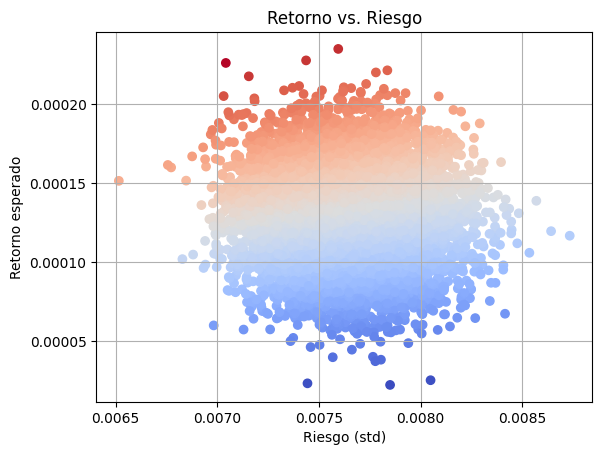

In [34]:

returns = get_data(csv=True)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'asset40', 'asset34', 'asset22', 'asset21', 'asset41', 'asset14', 'asset20', 'asset27', 'asset2', 'asset15'}
[39, 33, 21, 20, 40, 13, 19, 26, 1, 14]


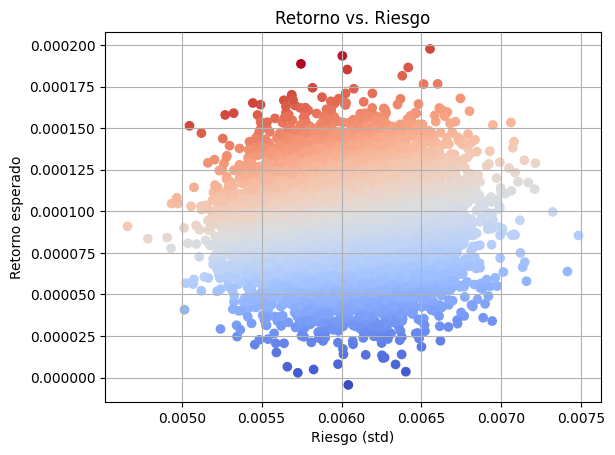

In [35]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 5):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.9) & (correlations < 1)].stack()

for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



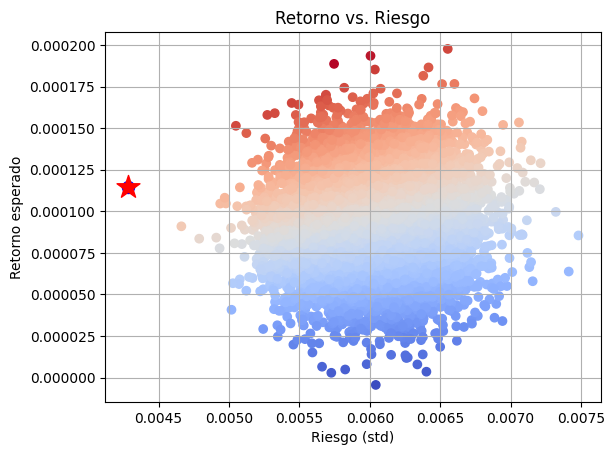

In [36]:
import cvxpy as cp

# 2% se refiere a anual
fixed_income_return = 0.02 / 252

# Los assets con correlacion inferior al 80% y curtosis <= 5 + renta fija
n_assets = len(returns.iloc[0]) + 1

# Retornos esperados
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, fixed_income_return)

# Matriz de covarianza
returns_cov = np.zeros((n_assets, n_assets))
returns_cov[:-1, :-1] = returns.cov().values

# CVXPY

w = cp.Variable(n_assets)
risk = cp.quad_form(w, returns_cov)

constraints = [
    w >= 0, # solo largos
    w[-1] <= 0.1, # renta fija max 10%
    w[:-1] <= 0.2,# Max un 20% en los activos
    cp.sum(w) == 1, # todo el dinero invertido
    w[drop_indexes] == 0, # No invertimos en los que hemos descartado antes
]

problem = cp.Problem(cp.Minimize(risk), constraints)
problem.solve(solver=cp.SCS)

weights = w.value
daily_return = returns_means @ weights
daily_volatility = np.sqrt(weights @ returns_cov @ weights.T)

sharpe = (daily_return - fixed_income_return) / daily_volatility

plot_sharpe(returns, mask, pd.DataFrame([[daily_return, daily_volatility, sharpe]], columns=['return', 'volatility', 'sharpe']))


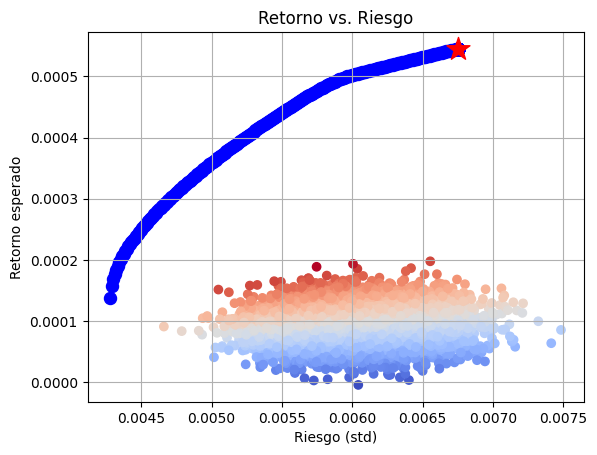

,return,volatility,sharpe,asset0,asset1,asset2,asset3,asset4,asset5,asset6,...,asset41,asset42,asset43,asset44,asset45,asset46,asset47,asset48,asset49,Renta Fija
155,0.000500,0.005963,0.070527,1.715188e-08,3.703981e-13,7.340105e-08,0.006475,1.060785e-07,0.200000,1.289518e-08,...,1.698655e-07,2.400598e-08,1.462042e-07,3.088563e-08,1.443432e-07,1.967055e-08,2.170121e-08,1.782573e-08,3.852165e-08,0.099999
154,0.000499,0.005952,0.070517,1.939788e-08,2.937909e-13,1.027348e-07,0.019100,2.057608e-04,0.200000,1.481605e-08,...,3.226808e-07,3.298427e-08,1.909811e-07,8.432158e-08,6.695041e-07,2.076208e-08,2.623344e-08,3.311424e-08,1.075518e-07,0.100000
156,0.000501,0.005974,0.070509,2.524743e-08,1.188978e-13,1.032751e-07,0.005826,1.429430e-07,0.200000,1.935173e-08,...,2.333047e-07,3.508370e-08,1.939820e-07,4.467720e-08,1.900801e-07,2.897295e-08,3.204474e-08,2.608510e-08,5.429785e-08,0.098613
157,0.000501,0.005985,0.070490,2.123714e-08,2.717781e-13,8.995073e-08,0.006254,1.309762e-07,0.200000,1.614289e-08,...,2.153748e-07,2.978642e-08,1.733715e-07,3.861794e-08,1.766844e-07,2.434037e-08,2.699910e-08,2.225749e-08,4.747222e-08,0.097084
158,0.000502,0.005995,0.070471,2.260720e-08,4.055520e-13,9.682859e-08,0.006659,1.425611e-07,0.200000,1.713871e-08,...,2.366510e-07,3.175829e-08,1.893937e-07,4.129331e-08,1.934125e-07,2.590950e-08,2.873966e-08,2.370084e-08,5.089196e-08,0.095561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.000184,0.004322,0.024244,2.502964e-08,6.212362e-13,1.601030e-07,0.004752,1.086356e-01,0.199999,2.241951e-08,...,2.389065e-07,6.962282e-08,2.057345e-07,1.999998e-01,1.225065e-02,2.040209e-08,3.753950e-08,5.985251e-07,8.634984e-02,0.100000
3,0.000177,0.004312,0.022640,1.275318e-08,1.855933e-13,8.118553e-08,0.002241,1.103754e-01,0.199998,1.174689e-08,...,1.235421e-07,3.672540e-08,9.859884e-08,1.999999e-01,1.188916e-02,1.029353e-08,1.948968e-08,4.248535e-04,9.096384e-02,0.100000
2,0.000168,0.004301,0.020621,6.250758e-09,1.617274e-13,4.029827e-08,0.000940,1.113955e-01,0.195321,5.861729e-09,...,6.194453e-08,1.871509e-08,4.777707e-08,2.000000e-01,1.203570e-02,4.976513e-09,9.641586e-09,6.318580e-03,9.438059e-02,0.100000
1,0.000157,0.004290,0.018025,8.691681e-10,1.413147e-14,5.895300e-09,0.001044,1.136833e-01,0.176641,8.428481e-10,...,8.899433e-09,2.750481e-09,7.401729e-09,2.000000e-01,1.427844e-02,6.726405e-10,1.355162e-09,1.276353e-02,9.845682e-02,0.100000


In [37]:

columns = ["return", "volatility", "sharpe"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
simulations = pd.DataFrame(columns=columns, dtype=float)

imax = np.argmax(returns_means)
for vol in np.linspace(daily_volatility, np.sqrt(returns_cov[imax, imax]), num=500):

    simulated_weights = cp.Variable(n_assets)
    riesgo = cp.quad_form(simulated_weights, returns_cov)
    constraints = [

        simulated_weights >= 0, # solo largos
        simulated_weights[-1] <= 0.1, # renta fija max 10%
        simulated_weights[:-1] <= 0.2,# Max un 20% en los activos
        cp.sum(simulated_weights) == 1, # todo el dinero invertido
        simulated_weights[drop_indexes] == 0, # No invertimos en los que hemos descartado antes
        riesgo <= vol**2, ## Limitamos el riesgo ##
    ]

    simulated_return = cp.Maximize(returns_means.T @ simulated_weights)
    prob = cp.Problem(simulated_return, constraints)
    resultado = prob.solve()

    used_vol = np.sqrt(riesgo.value)
    obtained_return = simulated_return.value
    obtained_sharpe_ratio = (obtained_return - fixed_income_return) / used_vol

    simulations.loc[len(simulations)] = np.concatenate([[obtained_return], [used_vol], [obtained_sharpe_ratio], simulated_weights.value])

simulations = simulations.sort_values(by='sharpe', ascending=False)
plot_sharpe(returns, mask, simulations)
simulations

In [38]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [39]:
rounded_weights = round_weights(simulations.iloc[0].tolist())
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)
print(f"Peso en {len(rounded_weights[rounded_weights > 0])} activos")

['0', '0.005', '0.07', '0', '0', '0', '0.006', '0', '0.199', '0', '0.199', '0', '0', '0', '0', '0.093', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.199', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.199', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.099']
Peso en 9 activos
